# Characterize potential i-band photometry issue

Midori noticed that a few of our long-term variables showed a "jump" in their i-band difference-image magnitudes around MJD = 59500. This notebook reproduces the behaviour and tries to quantify how many candidates are impacted.

**Takeaway:** We do find 22 candidates (out of the 8998 being published in the paper) exhibit a ~1 mag "jump" in the i-band around MJD-59500. They're all in ELAIS and all appear to be stellar.

**Question:** What caused this and is it something we can fix before publishing?

## Set up

In [1]:
import psycopg2
import psycopg2.extras
import getpass
import pandas

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from astropy.time import Time

from copy import deepcopy
import time

In [2]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")
db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")
db.autocommit = True
cursor = db.cursor(cursor_factory = psycopg2.extras.DictCursor)

DB User:  decat_ro
DB Password:  ········


In [3]:
tag = "latest"
db.rollback()
q = ( "SELECT id, tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print(tagid)

1


In [4]:
del dbuser, dbpasswd, db, tag, q, row

## Four example candidates

Four long-term variable candidates for which the i-band "jump" was noticed.

In [5]:
ex_cands = np.asarray(['DC21koqo','DC21kmdi','DC21ksgv','DC21kofv'], dtype='str')

### Retrive difference-image object photometry

In [6]:
%%time

tmp_str = "('DC21koqo', 'DC21kmdi', 'DC21ksgv', 'DC21kofv')"

q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, "
     "i.filter, i.meanmjd, o.candidate_id, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt "
     "ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE o.candidate_id IN " + tmp_str)
     # "WHERE ((od.ra > 147.0 AND od.ra < 153.0 AND od.dec > -0.25 AND od.dec < 5) "
     # "OR (od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41)) ")

cursor.execute(q, {'tagid': tagid})

del tmp_str, q, tagid
     
df = pandas.DataFrame(cursor.fetchall())

print(len(df))

4744
CPU times: user 21.5 ms, sys: 2.39 ms, total: 23.9 ms
Wall time: 172 ms


In [7]:
obj_ra     = np.asarray(df[0], dtype='float')
obj_dec    = np.asarray(df[1], dtype='float')
obj_mag    = np.asarray(df[2], dtype='float')
obj_mage   = np.asarray(df[3], dtype='float')
obj_rb     = np.asarray(df[4], dtype='float')
obj_filt   = np.asarray(df[5], dtype='str')
obj_mjd    = np.asarray(df[6], dtype='float')
obj_candid = np.asarray(df[7], dtype='str')
obj_propid = np.asarray(df[8], dtype='str')
del df

### Plot the light curves

In [8]:
fnames = ['g','r','i']
fcolors = ['green','red','blue']
fshapes = ['o','s','*']
fsizes  = [5, 5, 7]

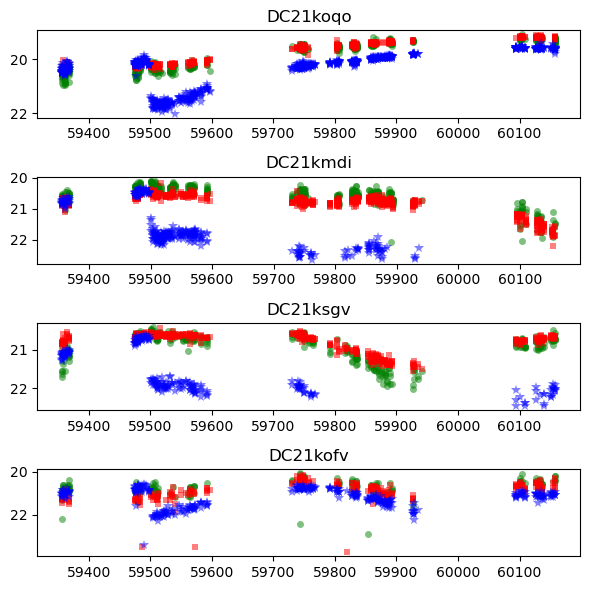

In [9]:
fig, ax = plt.subplots(4, figsize=(6, 6), sharex=False, sharey=False)
for c, cand in enumerate(ex_cands):
    for f, filt in enumerate(fnames):
        tx = np.where((obj_candid == cand) & (obj_filt == filt))[0]
        ax[c].plot(obj_mjd[tx], obj_mag[tx], fshapes[f], ms=fsizes[f], 
                   alpha=0.5, mew=0, color=fcolors[f])
    ax[c].set_title(cand)
    ax[c].invert_yaxis()
fig.tight_layout()
fig.show()

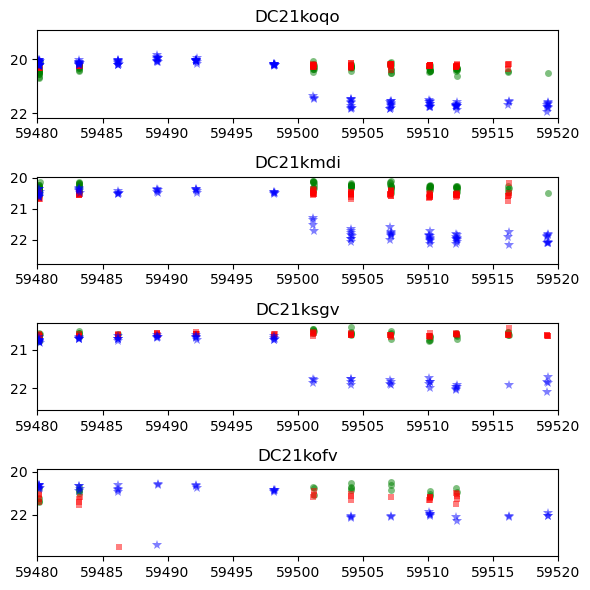

In [10]:
fig, ax = plt.subplots(4, figsize=(6, 6), sharex=False, sharey=False)
for c, cand in enumerate(ex_cands):
    for f, filt in enumerate(fnames):
        tx = np.where((obj_candid == cand) & (obj_filt == filt))[0]
        ax[c].plot(obj_mjd[tx], obj_mag[tx], fshapes[f], ms=fsizes[f], 
                   alpha=0.5, mew=0, color=fcolors[f])
    ax[c].set_xlim([59480, 59520])
    ax[c].set_title(cand)
    ax[c].invert_yaxis()
fig.tight_layout()
fig.show()

In [11]:
del cursor
del obj_ra, obj_dec, obj_mag, obj_mage
del obj_rb, obj_filt, obj_mjd, obj_candid, obj_propid
del fig

## Quantify impact

For the paper we're using the 8998 candidates identified as 'likely real'. 

Look for this jump in the nightly-epoch light curves.

Find out how many candidates being used for the paper might be affected.

### Read nightly-epoch light curves

In [12]:
fnm = '../all_nightly_epochs_files/candidate_lightcurves.dat'
candLC_field = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_lef = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

### Plot again for the four examples

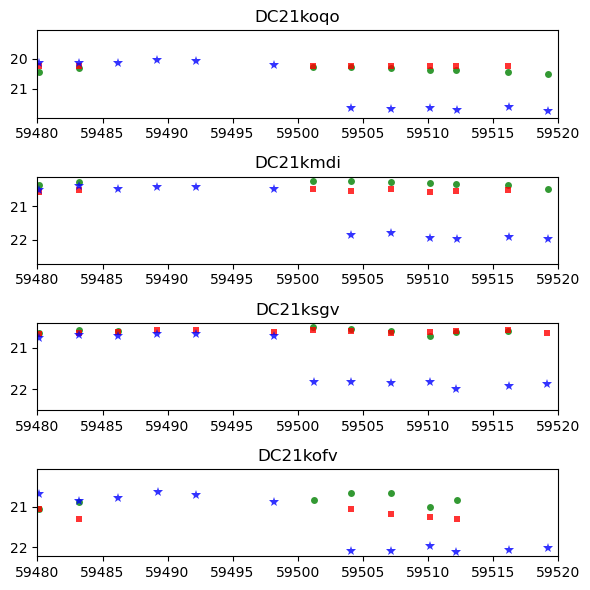

In [13]:
fig, ax = plt.subplots(4, figsize=(6, 6), sharex=False, sharey=False)
for c, cand in enumerate(ex_cands):
    for f, filt in enumerate(fnames):
        tx = np.where((candLC_candid == cand) & (candLC_filter == filt))[0]
        ax[c].plot(candLC_mjd[tx], candLC_mag[tx], fshapes[f], ms=fsizes[f], 
                   alpha=0.8, mew=0, color=fcolors[f])
    ax[c].set_xlim([59480, 59520])
    ax[c].set_title(cand)
    ax[c].invert_yaxis()
fig.tight_layout()
fig.show()

### Number of candidates with a "jump" around MJD 59500 

First, the number of unique candidates. Will be 8998.

In [14]:
ucands = np.unique(candLC_candid)
print(len(ucands))

8998


Store the mean magnitude in the days before/after MJD 59500 as m1 and m2.

In [15]:
%%time
m1 = np.zeros(len(ucands), dtype='float')
m2 = np.zeros(len(ucands), dtype='float')
for u, ucand in enumerate(ucands):
    tx = np.where((candLC_candid == ucand) & (candLC_filter == 'i'))[0]
    x1 = np.where((candLC_mjd[tx] >= 59480) & (candLC_mjd[tx] < 59500))[0]
    x2 = np.where((candLC_mjd[tx] > 59500) & (candLC_mjd[tx] <= 59515))[0]
    if (len(x1) > 0) & (len(x2) > 0):
        m1[u] = np.mean(candLC_mag[tx[x1]])
        m2[u] = np.mean(candLC_mag[tx[x2]])
    del tx, x1, x2

CPU times: user 10.8 s, sys: 1.98 ms, total: 10.8 s
Wall time: 10.8 s


Number of candidates that have data before/after MJD 59500.

In [16]:
tx = np.where(m1 > 0)[0]
print(len(tx))
del tx

78


Calculate the difference, before and after MJD 59500.

In [17]:
diff = m2 - m1

Plot the distribution of non-zero differences.

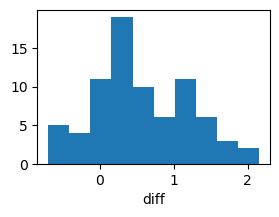

In [18]:
fig = plt.figure(figsize=(3, 2))
tx = np.where(diff != 0.0)[0]
plt.hist(diff[tx])
plt.xlabel('diff')
plt.show()
del tx

Identify candidates with a 1-mag jump like the candidates that Midori found.

In [19]:
tx = np.where(diff > 1)[0]
print(len(tx))
del tx

22


Were all four of the examples re-discovered?

In [20]:
tx = np.where(diff > 1)[0]
count = 0
for ecand in ex_cands:
    ex = np.where(ucands[tx] == ecand)[0]
    count += len(ex)
    del ex
print(count)
del tx, count

4


Make a list of the 22 "affected candidates".

In [21]:
tx = np.where(diff > 1)[0]
af_cands = ucands[tx]
del tx

### Plot light curves for the 22 candidates with i-band "jumps" >1 mag

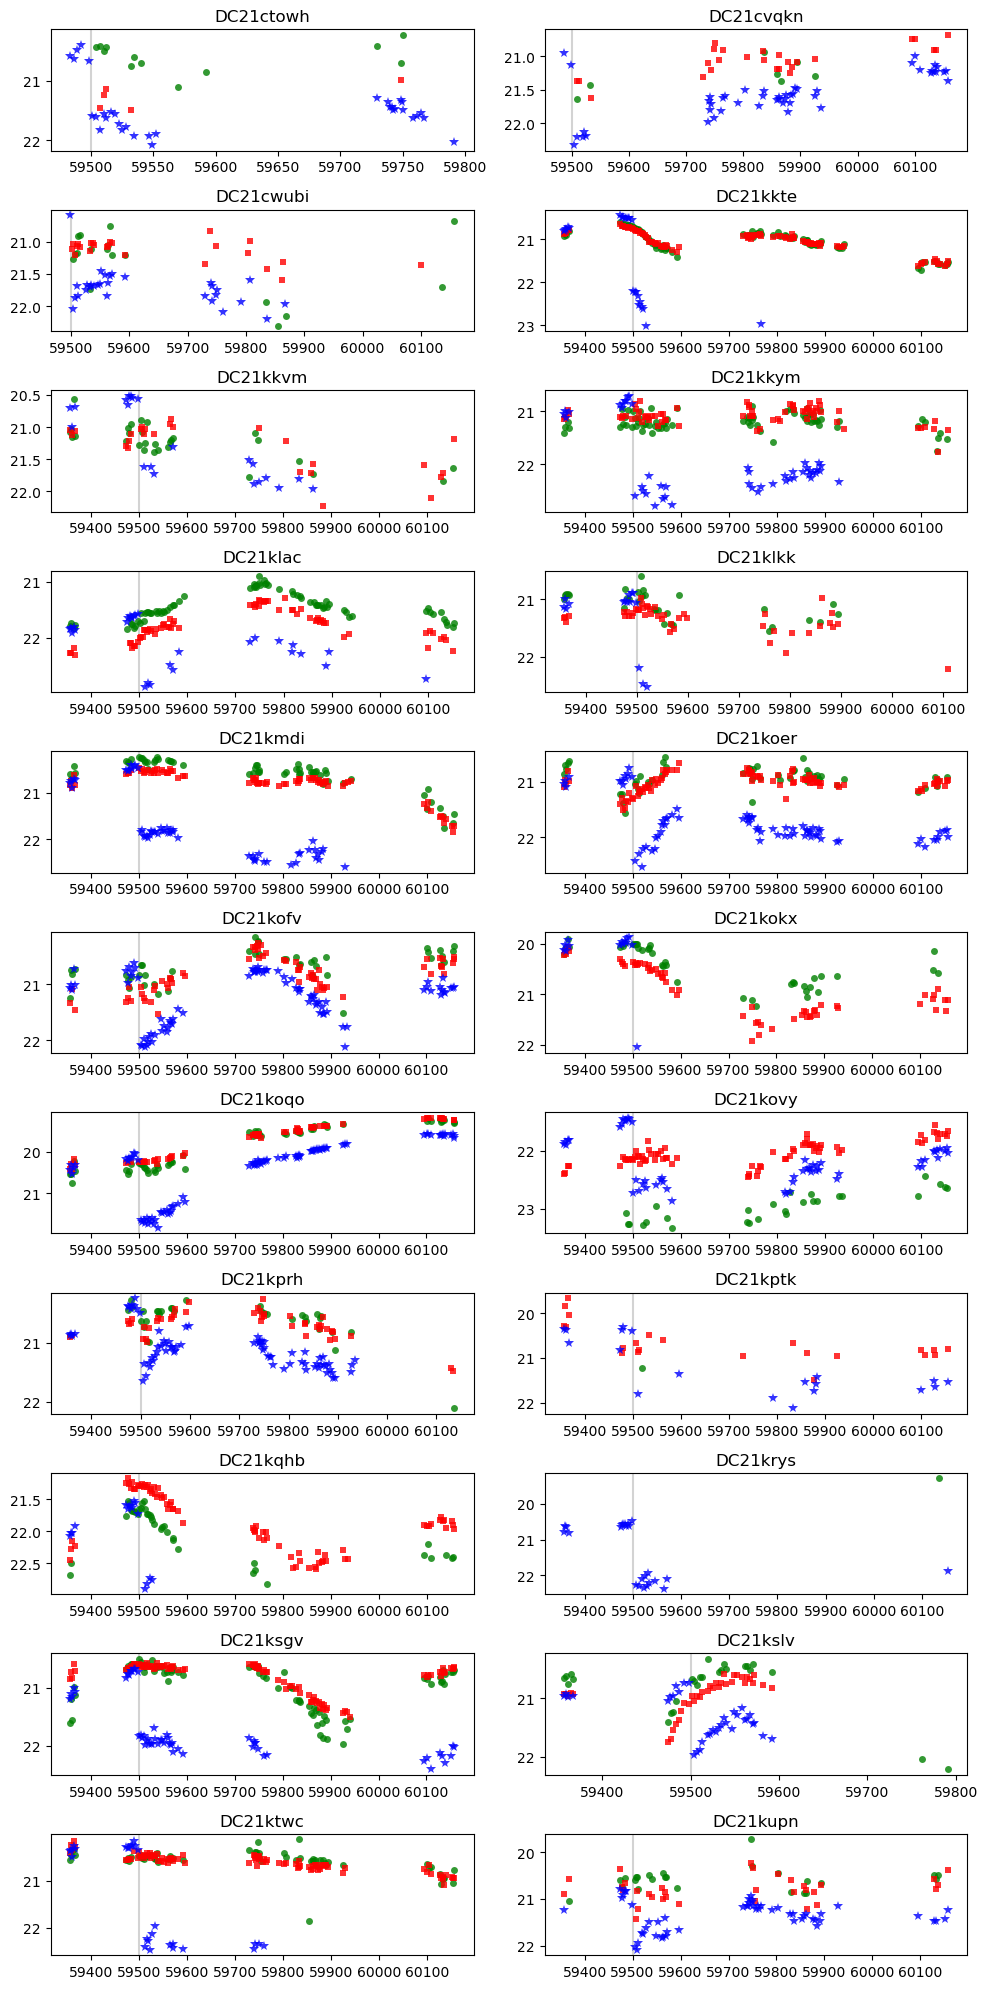

In [22]:
nrows = 11
ncols = 2
fig, ax = plt.subplots(nrows, ncols, figsize=(10, 20), sharex=False, sharey=False)
c = 0
for i in range(nrows):
    for j in range(ncols):
        cand = af_cands[c]
        ax[i, j].axvline(59500, color='lightgrey')
        for f, filt in enumerate(fnames):
            tx = np.where((candLC_candid == cand) & (candLC_filter == filt))[0]
            ax[i, j].plot(candLC_mjd[tx], candLC_mag[tx], fshapes[f], ms=fsizes[f], 
                       alpha=0.8, mew=0, color=fcolors[f])
            del tx
        # ax[i, j].set_xlim([59480, 59520])
        ax[i, j].set_title(cand)
        ax[i, j].invert_yaxis()
        del cand
        c += 1
fig.tight_layout()
fig.show()
del nrows, ncols, c

### Check if they're all in the same area in ELAIS

In [23]:
fnm = '../all_nightly_epochs_files/candidate_coordinates.dat'
cc_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
cc_ra = np.loadtxt(fnm, dtype='float', usecols=(1))
cc_dec = np.loadtxt(fnm, dtype='float', usecols=(2))
del fnm

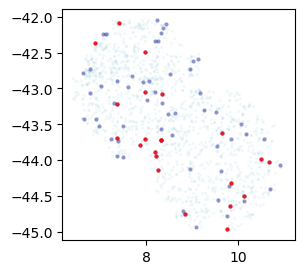

In [24]:
fig = plt.figure(figsize=(3, 3))

tx = np.where((cc_ra > 5.0) & (cc_ra < 12.0) & 
              (cc_dec > -46) & (cc_dec < -41))[0]
plt.plot(cc_ra[tx], cc_dec[tx], 'o', ms=2,
         alpha=0.2, mew=0, color='lightblue')
del tx

tx = np.where(diff != 0.0)[0]
tmp_cands = ucands[tx]
del tx
for cand in tmp_cands:
    tx = np.where(cc_candid == cand)[0]
    plt.plot(cc_ra[tx[0]], cc_dec[tx[0]], 'o', ms=3, 
             alpha=0.4, mew=0, color='darkblue')
    del tx
del tmp_cands

for cand in af_cands:
    tx = np.where(cc_candid == cand)[0]
    plt.plot(cc_ra[tx[0]], cc_dec[tx[0]], 'o', ms=3,
             alpha=0.8, mew=0, color='red')
    del tx

plt.show()

No they're scattered across the region.

### Check if the 22 candidates are cross-matched with stars or galaxies

In [25]:
fnm = '../cross_matched_LSDR10/candidate_xmatch_LSdr10.dat'
lsdr10xm_candid   = np.loadtxt(fnm, dtype='str', usecols=(0))
lsdr10xm_flagstar = np.loadtxt(fnm, dtype='int', usecols=(4))
lsdr10xm_flagcore = np.loadtxt(fnm, dtype='int', usecols=(5))
lsdr10xm_flagmatch= np.loadtxt(fnm, dtype='int', usecols=(6))
lsdr10xm_rmag     = np.loadtxt(fnm, dtype='float', usecols=(13))
del fnm

In [26]:
for cand in af_cands:
    tx = np.where(lsdr10xm_candid == cand)[0]
    tmp1 = '      '
    tmp2 = '    '
    if lsdr10xm_flagstar[tx[0]] == 1:
        tmp1 = 'star'
    elif lsdr10xm_flagstar[tx[0]] == 0:
        tmp1 = 'galaxy'
        if lsdr10xm_flagcore[tx[0]] == 1:
            tmp2 = 'core'
    print('%12s %10s %5s %5.2f' % (cand, tmp1, tmp2, lsdr10xm_rmag[tx[0]]))
    del tx, tmp1, tmp2

   DC21ctowh       star       19.03
   DC21cvqkn       star       19.04
   DC21cwubi       star       18.94
    DC21kkte       star       21.37
    DC21kkvm       star       18.94
    DC21kkym     galaxy  core 19.91
    DC21klac       star       21.66
    DC21klkk       star       19.96
    DC21kmdi       star       19.67
    DC21koer       star       19.89
    DC21kofv       star       19.29
    DC21kokx       star       19.61
    DC21koqo       star       19.31
    DC21kovy       star       22.71
    DC21kprh       star       18.76
    DC21kptk       star       18.66
    DC21kqhb       star       21.10
    DC21krys       star       19.21
    DC21ksgv       star       20.10
    DC21kslv     galaxy  core 20.37
    DC21ktwc       star       19.85
    DC21kupn       star       19.14


### Print the links for follow-up

Links to the Legacy Survey stamp and to Rob Knop's candidate viewer pages.

By checking the LS stamps, looks like even the two that were cross-matched
to "galaxies" were probably stars.

In [27]:
fnm = '../cross_matched_LSDR10/candidate_links.dat'
link_candid  = np.loadtxt(fnm, dtype='str', usecols=(0))
link_LSstamp = np.loadtxt(fnm, dtype='str', usecols=(1))
link_RKviewer = np.loadtxt(fnm, dtype='str', usecols=(2))
del fnm

In [28]:
for cand in af_cands:
    tx = np.where(link_candid == cand)[0]
    print(cand)
    print(link_LSstamp[tx[0]])
    print(link_RKviewer[tx[0]])
    del tx

DC21ctowh
https://www.legacysurvey.org/viewer/cutout.jpg?ra=9.75167412479389&dec=-44.9557989384161&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21ctowh
DC21cvqkn
https://www.legacysurvey.org/viewer/cutout.jpg?ra=7.98367654957176&dec=-43.7071210541121&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21cvqkn
DC21cwubi
https://www.legacysurvey.org/viewer/cutout.jpg?ra=8.32659161738543&dec=-43.7174193067873&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21cwubi
DC21kkte
https://www.legacysurvey.org/viewer/cutout.jpg?ra=7.96534486286685&dec=-43.0437519258403&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21kkte
DC21kkvm
https://www.legacysurvey.org/viewer/cutout.jpg?ra=8.32618349744129&dec=-43.7169216595945&layer=ls-dr9&pixscale=0.06
https://decat-webap.lbl.gov/decatview.py/cand/DC21kkvm
DC21kkym
https://www.legacysurvey.org/viewer/cutout.jpg?ra=7.37133951168021&dec=-43.6895067331